## Task 4.4: Supervised ML - Classification and hyperparam tuning

**Author**: Andre Schomakers

**Date**: 09 Mar 2025

This interactive Python notebook `.ipynb` is used for supervised regression for task 4.4.

### Imports and some basic processing

In [28]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
cox2_df = pd.read_csv("cox2.csv")
cox2_df # (462x257)

,QikProp_.stars,QikProp_.amine,QikProp_.acid,QikProp_.rotor,QikProp_.rctvFG,QikProp_CNS,QikProp_MW,QikProp_dipole,QikProp_SASA,QikProp_FOSA,...,moe2D_vsa_acc,moe2D_vsa_don,moe2D_vsa_hyd,moe2D_vsa_other,moe2D_vsa_pol,moe2D_weinerPath,moe2D_weinerPol,moe2D_zagreb,IC50,cox2Class
0,1,0,0,1,0,0,358.882,7.645,635.022,273.363,...,32.02,0.00,268.2,6.513,0.00,1340,37,138,0.001,Inactive
1,0,0,0,2,0,-1,359.870,7.959,622.548,189.930,...,32.02,20.14,236.8,10.110,0.00,1340,37,138,0.001,Inactive
2,0,0,0,3,0,-1,355.451,7.500,610.972,268.526,...,34.52,20.14,238.4,18.560,0.00,1524,39,142,0.001,Inactive
3,1,0,0,2,0,-1,393.423,9.342,651.852,190.772,...,32.02,20.14,249.7,10.110,0.00,1898,43,156,0.001,Inactive
4,1,0,0,2,0,-1,394.315,9.409,637.688,189.933,...,32.02,20.14,255.1,10.110,0.00,1486,40,144,0.001,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2,0,0,1,0,0,461.928,6.419,701.162,83.433,...,37.70,0.00,316.0,21.890,0.00,2373,50,164,100.000,Active
458,1,0,0,1,0,0,316.349,8.097,537.398,83.436,...,32.02,0.00,209.9,13.210,18.84,1099,33,118,100.000,Active
459,2,0,0,1,0,0,384.348,6.748,583.611,84.427,...,32.02,0.00,234.4,19.910,18.84,1626,42,142,100.000,Active
460,0,0,0,3,0,0,356.414,8.417,633.843,200.694,...,41.44,0.00,275.4,13.210,0.00,1529,38,132,100.000,Active


In [ ]:
# using value_counts() method to inspect our target

cox2_df["cox2Class"].value_counts()
    # Inactive = 372
    # Active = 90
    # caution: imbalanced target. we need to avoid interpreting the accuracy or state the imbalance problem in our limitations

cox2Class
Inactive    372
Active       90
Name: count, dtype: int64

In [ ]:
cox2_df.isna().sum().sum()
# no missing vals (didnt check for unplausible values within all the features. it's a lot of them)
# in a real setting i would take the time to double check for these type of missing values

np.int64(0)

In [ ]:
# prep X and y
# 'cox2Class' is the target variable
X = cox2_df.drop('cox2Class', axis=1)
y_raw = cox2_df['cox2Class']

# encode the target 'cox2Class' (Active=1, Inactive=0)
y = y_raw.map({'Active': 1, 'Inactive': 0})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # important for imbalanced dataset to ensure representative class sizes according to our proportion
)

### RandomForestClassifier and GridSearchCV setup

In [11]:
rf_model = RandomForestClassifier(random_state=42)


In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],      # n trees in the forest
    'max_depth': [None, 10, 20],         # max depth of the tree
}

In [14]:
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,     # put our defined grid as param 
    cv=10,                     # 10-fold cross-val
    scoring='f1',              # we are using the f1 score due to the imbalance
    n_jobs=-1,                 # Use all available cores
    verbose=1                  # Print progress
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=1)

In [ ]:
# extract the best parameters and the best score for training
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest cross-validation accuracy score:")
print(f"{grid_search.best_score_:.4f}")


Best parameters found by GridSearchCV:
{'max_depth': None, 'n_estimators': 200}

Best cross-validation accuracy score:
0.9305


In [ ]:
# extract best model for prediction
best_rf_model = grid_search.best_estimator_


### Prediction and Evaluation of Test-Set using the best model

In [ ]:
# get feature importances from the best model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# df for feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance_df.head(10))
# i skip on displaying these features with matplotlib 
# ... i would need more context from the attached paper in order to interpret them accordingly and derive further steps


Top 10 Feature Importances:
                  feature  importance
255                  IC50    0.264151
170            moe2D_bpol    0.016895
234            moe2D_logS    0.013632
93   moe2D_PEOE_VSA_FPPOS    0.012200
33      QikProp_QPlogKhsa    0.011484
15        QikProp_accptHB    0.011409
41      moe2D_BCUT_PEOE_2    0.010130
117        moe2D_SMR_VSA0    0.009985
99    moe2D_PEOE_VSA_PPOS    0.009902
30         QikProp_IP.eV.    0.009899


In [19]:
# actual predictions
y_pred_test = best_rf_model.predict(X_test)
y_pred_proba_test = best_rf_model.predict_proba(X_test)[:, 1] # probas for the positive class (Active)

In [ ]:
# we are skipping on the accuracy due to class imbalance!!

# ROC AUC Score
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
print(f"ROC AUC Score: {roc_auc_test:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Inactive (0)', 'Active (1)']))

# we can observe a decent f1-score on the test set for predicting "Active" == 1 with 0.91

ROC AUC Score: 0.9953

Classification Report:
              precision    recall  f1-score   support

Inactive (0)       0.98      0.98      0.98        93
  Active (1)       0.91      0.91      0.91        23

    accuracy                           0.97       116
   macro avg       0.95      0.95      0.95       116
weighted avg       0.97      0.97      0.97       116




Confusion Matrix:


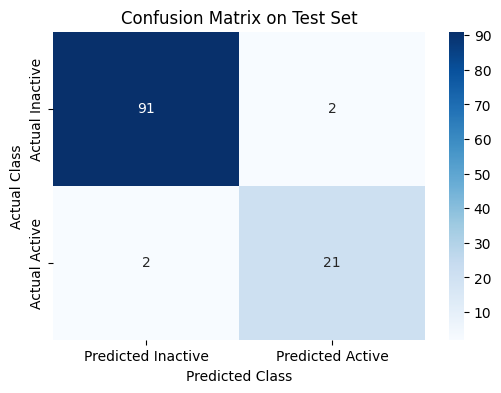

In [22]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Inactive', 'Predicted Active'],
            yticklabels=['Actual Inactive', 'Actual Active'])
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


Test Set ROC AUC Score (F1-tuned model): 0.9953


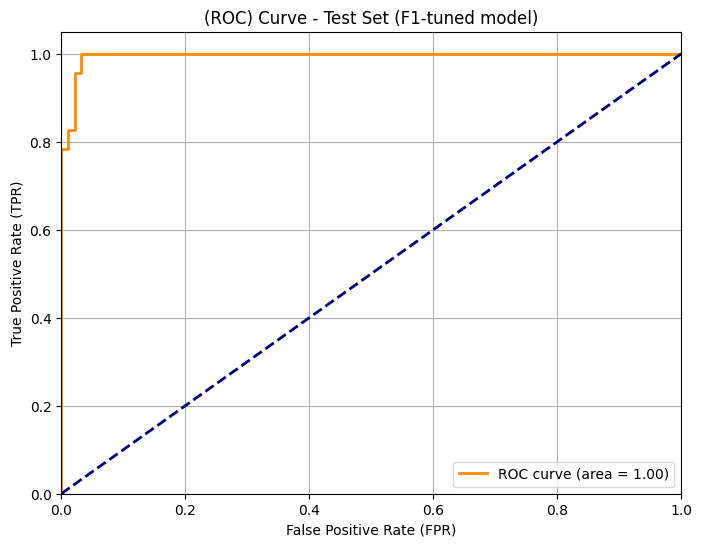

In [30]:
# ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc_test_f1 = auc(fpr, tpr) # or roc_auc_score(y_test, y_pred_proba_test_f1)

print(f"\nTest Set ROC AUC Score (F1-tuned model): {roc_auc_test_f1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_f1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(ROC) Curve - Test Set (F1-tuned model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Final thoughts**:

The hyperparameter tuning this time worked a little better compared to the regression task. However I'd add as a limitation again, that I didnt find the time to dive deep into the paper understanding its content. Real hyperparameter tuning is based exactly on this and combination to a solid understanding how learning parameters work, e.g. `n_estimators` or `max_depth` (of each decision tree in a random forest).

Based on the given class imbalance of the dataset, I did use the f1-score as a scoring argument for `GridSearchCV` instead of the accuracy. The F1 is the harmonic mean of precision and recall, also mapped to a range of $[0,1]$, where 1 is a perfect F1. The F1 provides better measure of the models performance by balancing the precision (minimizing FPR) and recall (minimizing FNR) for the positive class (="active COX 2 inhibitors").

Based on the confusion matrix and the class report, we can see that the f1 score for the minority class "Active" yields 0.91 which seems like a robust model performance.